In [127]:
import graphviz as gv
import copy

#helper functions
op=lambda i: i[0]
i0=lambda i: i[1]
i1=lambda i: i[2]
output=lambda i: i[3]
block=lambda i: i[4].strip('\n')
block_of_label=lambda lab,instructions: [block(i) for i in instructions if (op(i)=='Label' and i0(i)==lab)][0]
instruction=lambda i: (op(i),i0(i),i1(i),output(i),block(i))
jumpto_uncond=lambda i, instructions: block_of_label(i0(i),instructions)
jumpto_cond=lambda i, instructions: block_of_label(i1(i),instructions)
instructions_in_block = lambda b,instructions: [instruction(i) for i in instructions if block(i)==b] #extract all instructions from block b
block_contains_op = lambda l, op_, instructions: True if op_ in [op(i) for i in instructions_in_block(l)] else False

def print_ins(ins):
    space=lambda x, n: n-len(x)
    def empty(z): 
        e=''
        for i in range(z):e+=' '
        return e
    fill=lambda x, width: x+empty(space(x,width))
    for i in ins:print(fill(i[0],12),'\t',fill(i[1],6),'\t',fill(i[2],6),'\t',fill(i[3],6),'\t',fill(i[4].strip('\n'),6))        

def load_il(fname):
    with open(fname+'.ins','r') as f:
        operations=f.readlines()
        instructions=[o.split(' ') for o in operations]
    with open(fname+'.vars','r') as f:
        v=f.readlines()
        v=[i.split(' ') for i in v]
        stack_var_map={i[0]:i[1].strip('\n') for i in v}
    return instructions,stack_var_map
    
def make_cfg(fname,printIns=False):    
    cfg={}
    #load all instructions
    instructions,stack_var_map=load_il(fname)

    gen_ins=('Plus','Minus','Times','Greater','And','Or','GreaterEq','Equal','Not','Move')
    
    check_gen=lambda i,f: True if (f(i)!='null' and op(i) in gen_ins and f(i) in list(stack_var_map)) else False
    check_kill=lambda i: True if (output(i)!='null' and output(i) in list(stack_var_map)) else False
    gen=lambda b: set([stack_var_map[i0(i)] for i in instructions_in_block(b,instructions) if check_gen(i,i0)]+ 
                           [stack_var_map[i1(i)] for i in instructions_in_block(b,instructions) if check_gen(i,i1)])
    kill=lambda b: set([stack_var_map[output(i)] for i in instructions_in_block(b,instructions) if check_kill(i)])
    
    def connect(i,x,edge_annotation=''): 
        assert i!=x,'self-connection detected'
        if block(i) not in cfg: cfg[block(i)]={'succ':[],'succ_labels':[]}
#         if x not in [z[0] for z in cfg[block(i)]]:
        cfg[block(i)]['succ'].append(x)
        cfg[block(i)]['succ_labels'].append(edge_annotation)
        
    if printIns: print_ins(instructions)

    #main loop
    for ni,i in enumerate(instructions[:-1]):
        next_i=instructions[ni+1]
        if ni>0: prev_i=instructions[ni-1]
        if op(i) == 'Jump': connect(i,jumpto_uncond(i,instructions),edge_annotation=' j ')
        if op(i) in ('JumpIfNonzero','JumpIfZero'): 
            connect(i,jumpto_cond(i,instructions),edge_annotation=' if ')
            connect(i,block(next_i),edge_annotation=' else ')
        if (block(i) != block(next_i)) and (op(i)[:4]!='Jump'): connect(i,block(next_i))
    
    for i in set([block(j) for j in instructions]):
        if i not in cfg:cfg[i]={'succ':[],'succ_labels':[]}
        cfg[i]['gen']=gen(i)
        cfg[i]['kill']=kill(i)

    return cfg

def visualize(cfg,cfg_name,save=False):
    dot=gv.Digraph(name=cfg_name,
                   graph_attr={'bgcolor':'#24283B','pad':'0.5'},
                  node_attr={'fontsize':'12','fontcolor':'#ffffff','color':'#E0AF68','fontname':'Hack, monospace','shape':'underline'},
                  edge_attr={'color':'#E0AF68','arrowsize':'0.5','fontcolor':'#ffffff','fontsize':'12'})
    gen=lambda i:'{}' if cfg[i]['gen']==set() else str(cfg[i]['gen'])
    kill=lambda i:'{}' if cfg[i]['kill']==set() else str(cfg[i]['kill'])
    name=lambda i: '---'+i+'---\nGen '+gen(i)+'\nKill '+kill(i)
    for l in cfg:
        for n in cfg[l]['succ']: dot.node(name(n))
    for l in cfg:
        for node_name,edge_name in zip(cfg[l]['succ'],cfg[l]['succ_labels']):  
            dot.edge(name(l),name(node_name),label=edge_name)
    if save: dot.render('../programs/dot-files/'+cfg_name+'.dot')
    return dot

def fixed_point_iteration(iteration_function,cfg):
    init_data=iteration_function(cfg)
    iteration_data={0:init_data}
    iteration=1
    iteration_data[iteration]=iteration_function(cfg,init_data)
    while iteration_data[iteration]!=iteration_data[iteration-1]:
        iteration+=1
        iteration_data[iteration]=iteration_function(cfg,iteration_data[iteration-1])
    return iteration_data

cfg_collatz=make_cfg('../programs/collatz')
cfg_arith=make_cfg('../programs/arith')
cfg_factorial=make_cfg('../programs/factorial')
cfg_fib=make_cfg('../programs/fib')
cfg_dead=make_cfg('../programs/dead-code-test-1',True)

LoadConstant 	 1      	 null   	 3      	 1     
Move         	 3      	 null   	 1      	 1     
LoadConstant 	 2      	 null   	 3      	 2     
Move         	 3      	 null   	 2      	 2     
LoadConstant 	 3      	 null   	 7      	 3     
Plus         	 2      	 7      	 5      	 3     
Plus         	 1      	 5      	 3      	 3     
Move         	 3      	 null   	 0      	 3     


LoadConstant 	 1      	 null   	 3      	 1     
Move         	 3      	 null   	 1      	 1     
LoadConstant 	 2      	 null   	 3      	 2     
Move         	 3      	 null   	 2      	 2     
LoadConstant 	 3      	 null   	 7      	 3     
Plus         	 2      	 7      	 5      	 3     
Plus         	 1      	 5      	 3      	 3     
Move         	 3      	 null   	 0      	 3     
---


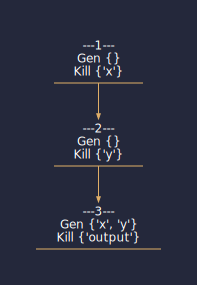

In [149]:
def iterate_reaching_definitions(cfg_,init_data=None):
    data=copy.deepcopy(init_data)
# #     varnames={'0':'a','1':'b','5':'z','2':'n','4':'t','3':'output'}#fib
    varnames={'2':'y','1':'x','3':'z','0':'output'}#fact
    allvars={varnames[i] for i in varnames}
#     cfg={i:{'gen':set(),'kill':set(),'succ':cfg_[i]['succ']} for i in list(cfg_)}
#     for i in cfg_:
#         for j in ('gen','kill'):
#             for k in cfg_[i][j]:
#                 if k in list(varnames): cfg[i][j].add(varnames[k])
    labels=list(cfg)
    
    #Empty data structure, for first iteration in fixed point analysis
    if init_data is None: return {'rd_entry':{i:set() for i in labels},'rd_exit':{i:set() for i in labels}}
    
    def entry(i):
        _entry=copy.deepcopy(init_data['rd_entry'][i])
        if i=='1':
            return set([(v,'?') for v in allvars])
        else:
            for l in labels:
                if i in cfg[l]['succ']:
                    _entry=_entry.union(init_data['rd_exit'][l])
        return _entry
    
    def exit(i):
        _exit=copy.deepcopy(init_data['rd_entry'][i])
        for v in cfg[i]['kill']:
            for l in labels+['?']:
                _exit=_exit-set([(v,l)])
            _exit.add((v,i))
        return _exit
    
    for i in labels:
        data['rd_entry'][i]=entry(i)
    for i in labels:
        data['rd_exit'][i]=exit(i)
    return data

cfg=cfg_dead
iteration_function=iterate_reaching_definitions
rd_iterations= fixed_point_iteration(iteration_function,cfg)
rd_final=rd_iterations[list(rd_iterations)[-1]]

def instruction_number_of_label(instructions,l):
    for ni,i in enumerate(instructions):
        if int(block(i))==l: return ni
    assert False, 'block label not found'

# block_size=lambda l,instructions: len(instructions_in_block(l, instructions))
    
def const_def(v,l,instructions): #Return last constant assigned to variable v in block l if possible, else False
    b=instructions_in_block(l,instructions)
    next_ins=lambda i: b[i+1]
    for ins in b[::-1]:
        if (op(ins),op(next_ins))==('LoadConstant','Move'):
            const=i0(ins)
            var=varmap[output(next_ins)]
            if v==var: return const
    return False
    
cfg_dead=make_cfg('../programs/dead-code-test-1',True)
print('---')

def calculate(op,a,b):
    plus=lambda a,b: int(a)+int(b)
    minus=lambda a,b: int(a)-int(b)
    times=lambda a,b: int(a)*int(b)
    greater=lambda a,b: 1 if int(a)>int(b) else 0
    greater_eq=lambda a,b: 1 if int(a)>=int(b) else 0
    equal=lambda a,b: 1 if int(a)==int(b) else 0
    calc={'Plus':plus,'Minus':minus,'Times':times,'Greater':greater,'GreaterEq':greater_eq,'Equal':equal}
    return(calc[op](a,b))

def constant_folding(rd,program_name,cfg):
    instructions,varmap=load_il(program_name)
    stackmap={varmap[i]:i for i in varmap}
    labels=list(cfg)
    e=rd['rd_entry']
    undefined_in_l=lambda v,l: True if (v,'?') in e[l] else False    
    for l in labels:
        for v_,l_ in e[l]:
            const=const_def(v_,l_,instructions)
#             if not const: 

def fold_var_const(instructions,lines,var_stack_location,varval,delete=False):
    assert len(lines)==3
    const_def,const_save,operation=[instructions[i] for i in lines]
    assert op(const_def)=='LoadConstant'
    assert op(const_save)=='Move'
    assert op(operation) in ('Plus','Minus','Times','Greater','GreaterEq','Equal')
    constval=i0(const_def)
    if var_stack_location==i0(operation):
        operands=varval,constval
    elif var_stack_location==i1(operation):
        operands=constval,varval
    else: assert False, 'Var not in operation'
    folded_val = calculate(op(operation),operands[0],operands[1])
    new_ins = 'LoadConstant '+str(folded_val)+' null '+output(operation) #replace operation with loadconstant
    instructions[lines[2]]=new_ins
    if delete: return [instructions[i] for i in range(instructions) if i not in (lines[:2])]
    return instructions

def fold_var_var(instructions,line,var1_stack_location,var1_val,var2_stack_location,var2_val,delete=False):
    ins = instructions[line]
    assert var1_stack_location in [i0(ins),i1(ins)]
    assert var2_stack_location in [i0(ins),i1(ins)]
    if var1_stack_location == i0(ins):
        operands = var1_val,var2_val
    elif var1_stack_location == i1(ins):
        operands = var2_val,var1_val
    folded_val=calculate(op(ins),operands[0],operands[1])
    new_ins = 'LoadConstant '+str(folded_val)+' null '+output(ins)
    instructions[line]=new_ins
    if delete: return [instructions[i] for i in range(instructions) if i != line]
    return instructions

def fold_const_const(instructions,lines,delete=False):
    const1_def,const1_save,const2_def,const2_save,operation=[instructions[i] for i in lines]
    assert all([op(i)=='LoadConstant' for i in (const1_def,const2_def)])
    assert all([op(i)=='Move' for i in (const1_save,const2_save)])
    assert op(operation) in ('Plus','Minus','Times','Greater','GreaterEq','Equal')
    if output(const1_save)==i0(operation):
        operands=i0(const1_def),i0(const2_def)
    elif output(const1_save)==i1(operation):
        operands=i0(const2_def),i0(const1_def)
    folded_val=calculate(op(operation),operands[0],operands[1])
    new_ins = 'LoadConstant '+str(folded_val)+' null '+output(operation)
    instructions[lines[-1]]=new_ins
    if delete: return[instructions[i] for i in range(instructions) if i not in lines[:-1]]
    return instructions
    

    
# constant_folding(rd_final,'../programs/collatz','x')

# for i in rd_iterations:
#     for j in rd_iterations[i]:
#         for k in rd_iterations[i][j]:
#             print(i,j,k,rd_iterations[i][j][k],'\n')
# for i in rd_final:
#     for j in rd_final[i]:
#         print(i,j,rd_final[i][j],'\n')
visualize(cfg_dead,'dead.cfg',False)

In [84]:
def iterate_liveness(cfg,init_data=None):
    data=copy.deepcopy(init_data)
#     varnames={'0':'a','1':'b','5':'z','2':'n','4':'t','3':'output'}#fib
# #     varnames={'2':'y','1':'x','3':'z','0':'output'}#fact
#     cfg={i:{'gen':set(),'kill':set(),'succ':cfg_[i]['succ']} for i in list(cfg_)}
#     for i in cfg_:
#         for j in ('gen','kill'):
#             for k in cfg_[i][j]:
#                 if k in list(varnames): cfg[i][j].add(varnames[k])
    nBlocks=str(max([int(i) for i in cfg]))    
    
    if init_data is None: return {'in':{i:set() for i in list(cfg)},'out':{i:set() for i in list(cfg)}}
    
    def get_in(blocklabel):
        _in=cfg[blocklabel]['gen'].union(data['out'][blocklabel]-cfg[blocklabel]['kill'])
        return _in
    
    def get_out(blocklabel):
        _out=set()
        for j in cfg[blocklabel]['succ']: _out=_out.union(data['in'][j])
        return _out
    
    assert(not len(get_out(nBlocks))) #out set for the last block should be empty
    blocklabel=int(nBlocks)
    while 0<blocklabel:
        data['out'][str(blocklabel)]=get_out(str(blocklabel))
        data['in'][str(blocklabel)]=get_in(str(blocklabel))
        blocklabel-=1
    return data

cfg=cfg_fib
iteration_function=iterate_liveness
liveness_iterations= fixed_point_iteration(iteration_function,cfg)

for j in liveness_iterations:
    print('\n--------',j,'--------\n')
    print('in\n')
    for i in liveness_iterations[j]['in']:print(i,liveness_iterations[j]['in'][i])
    print('\nout\n')
    for i in liveness_iterations[j]['out']:print(i,liveness_iterations[j]['out'][i])


-------- 0 --------

in

1 set()
2 set()
3 set()
4 set()
5 set()
6 set()
7 set()
8 set()
9 set()
10 set()

out

1 set()
2 set()
3 set()
4 set()
5 set()
6 set()
7 set()
8 set()
9 set()
10 set()

-------- 1 --------

in

1 {'n'}
2 {'n', 'a'}
3 {'n', 'b', 'a'}
4 {'n', 'z', 'a', 'b'}
5 {'a', 'n', 'b'}
6 {'n', 'b', 't'}
7 {'n', 't'}
8 {'n'}
9 set()
10 {'a'}

out

1 {'n', 'a'}
2 {'n', 'b', 'a'}
3 {'n', 'z', 'b', 'a'}
4 {'a', 'n', 'b'}
5 {'n', 'b', 't'}
6 {'n', 't'}
7 {'n'}
8 set()
9 set()
10 set()

-------- 2 --------

in

1 {'n'}
2 {'n', 'a'}
3 {'n', 'b', 'a'}
4 {'n', 'z', 'a', 'b'}
5 {'a', 'n', 'b'}
6 {'n', 'b', 't'}
7 {'n', 't', 'a'}
8 {'n', 'b', 'a'}
9 {'n', 'b', 'a'}
10 {'a'}

out

1 {'n', 'a'}
2 {'n', 'b', 'a'}
3 {'n', 'z', 'b', 'a'}
4 {'a', 'n', 'b'}
5 {'n', 'b', 't'}
6 {'n', 't', 'a'}
7 {'n', 'b', 'a'}
8 {'n', 'b', 'a'}
9 {'n', 'z', 'b', 'a'}
10 set()

-------- 3 --------

in

1 {'n'}
2 {'n', 'a'}
3 {'n', 'b', 'a'}
4 {'n', 'z', 'a', 'b'}
5 {'a', 'n', 'b'}
6 {'n', 'b', 't'}
7 {'n', '

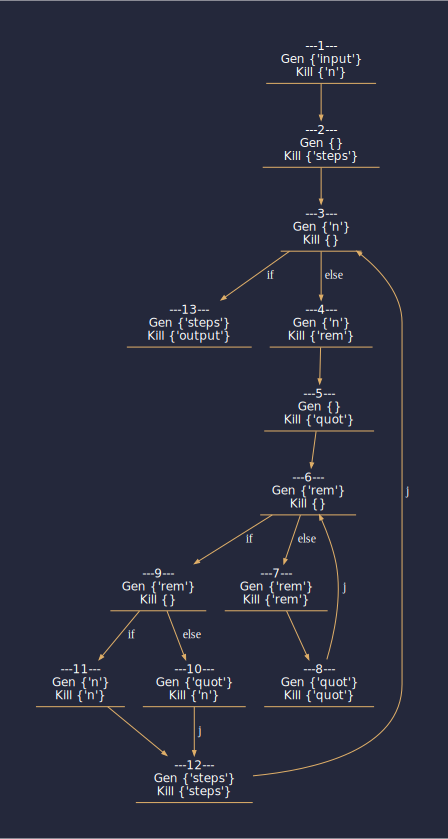

In [104]:
visualize(cfg_collatz,'collatz.cfg',save=False)

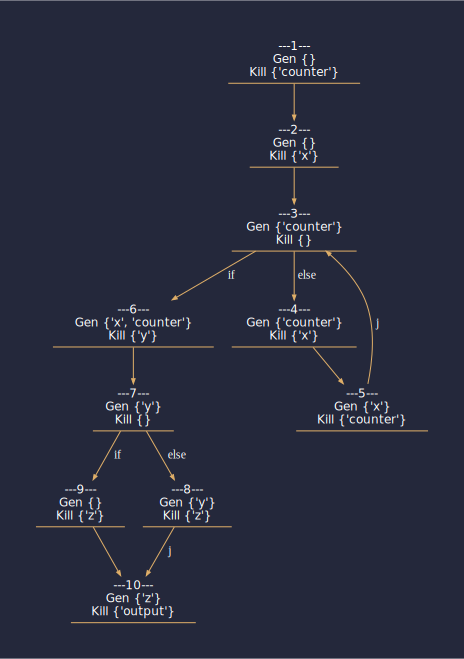

In [105]:
visualize(cfg_arith,'arith.cfg',save=False)

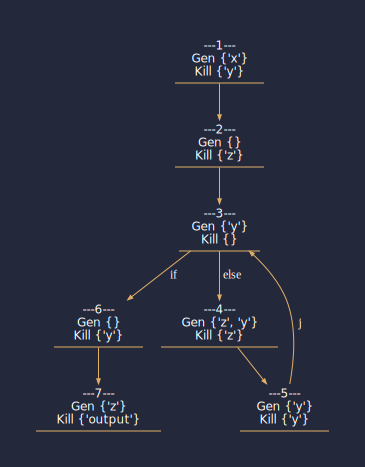

In [106]:
visualize(cfg_factorial,'factorial.cfg',save=False)

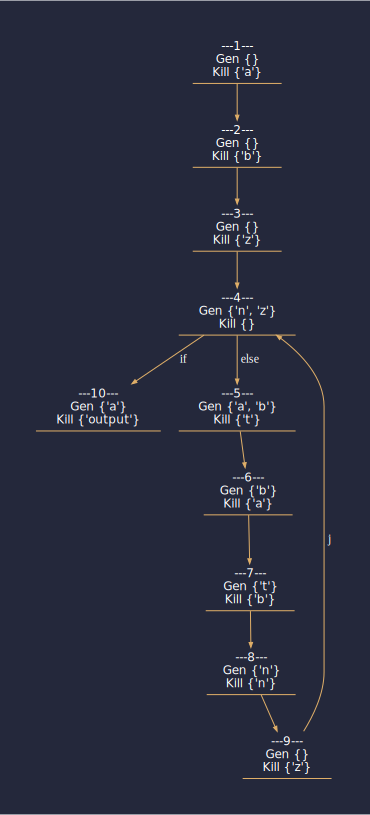

In [107]:
visualize(cfg_fib,'fig.cfg',save=False)

In [150]:
# def liveness(cfg_):
#     varnames={'0':'a','1':'b','5':'z','2':'n','4':'t','3':'output'}
#     cfg={i:{'gen':set(),'kill':set(),'succ':cfg_[i]['succ']} for i in list(cfg_)}
#     for i in cfg_:
#         for j in ('gen','kill'):
#             for k in cfg_[i][j]:
#                 if k in list(varnames): cfg[i][j].add(varnames[k])
    
#     nBlocks=str(max([int(i) for i in cfg]))    
#     for i in cfg:print('succ',cfg[i]['succ'],'gen',cfg[i]['gen'],'kill',cfg[i]['kill'],'\n')
    
#     def get_in(blocklabel,iteration):
#         _in=cfg[blocklabel]['gen'].union(liveness[iteration]['out'][blocklabel]-cfg[blocklabel]['kill'])
#         return _in
    
#     def get_out(blocklabel,iteration):
#         _out=set()
#         for j in cfg[blocklabel]['succ']: _out=_out.union(liveness[iteration]['in'][j])
#         return _out
    
#     assert(not len(get_out(nBlocks,0))) #out set for the last block should be empty
    
        
#     def iterate_liveness(iteration):
#         liveness[iteration]=copy.deepcopy(liveness[iteration-1])
#         blocklabel=int(nBlocks)
#         while 0<blocklabel:
#             liveness[iteration]['out'][str(blocklabel)]=get_out(str(blocklabel),iteration)
#             liveness[iteration]['in'][str(blocklabel)]=get_in(str(blocklabel),iteration)
#             blocklabel-=1
    
#     liveness={0:{'in':{i:set() for i in list(cfg)},'out':{i:set() for i in list(cfg)}}}
            
#     iteration=1    
#     iterate_liveness(iteration)
#     while liveness[iteration]!=liveness[iteration-1]:
#         iteration+=1
#         iterate_liveness(iteration)
        
#     return liveness
            
# liveness_data=liveness(cfg_fib)

# for j in liveness_data:
#     print('\n--------',j,'--------\n')
#     print('in\n')
#     for i in liveness_data[j]['in']:print(i,liveness_data[j]['in'][i])
#     print('\nout')
#     for i in liveness_data[j]['out']:print(i,liveness_data[j]['out'][i])

In [154]:
a = [1,2,3,4,5]


SyntaxError: cannot delete literal (1537733410.py, line 2)